# analytical method for correction of AuNRs 

In [1]:
import sys
# add path for my packages
sys.path.append('C:\\Users\\katsuya2\\OneDrive - University of Illinois - Urbana\\Documents\\Python Scripts\\my_packages')
import re
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import ast
import seaborn as sns
from scipy import optimize
from scipy.optimize import curve_fit
from scipy.stats import norm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
from pathlib import Path
from glob import glob
%precision 3
%matplotlib inline

# use my matplotlib style
style_p = Path("C:/Users/katsuya2/OneDrive - University of Illinois - Urbana/Documents/Python Scripts/my_packages")
plt.style.use(Path(style_p, 'my_rc_setting.mplstyle'))

import Lorentzian

## upload dataset

In [2]:
p = Path("C:/Users/katsuya2/OneDrive - University of Illinois - Urbana/Documents/Python Scripts/input_data/SPP2023")

# all glass data
glass_data = pd.read_csv(Path(p, '090723_glass_training.csv'))
glass_data['ratio'] = glass_data['length'] / glass_data['width']
glass_data = glass_data.drop(['corrcoef'], axis=1)
glass_data['volume'] = np.pi*(glass_data['width']**2)*glass_data['length']/4 - np.pi*(glass_data['width']**3)/12

# all ITO data
ito_data = pd.read_csv(Path(p, '111623_ito_training.csv'))
ito_data['ratio'] = ito_data['length'] / ito_data['width']
ito_data = ito_data.drop(['corrcoef'], axis=1)

# further control the dataset so that all aspect ratio in glass can fall into the range of ITO's ratio
ito_ratio_min = ito_data['ratio'].min()
ito_ratio_max = ito_data['ratio'].max()

glass_data = glass_data[(glass_data['ratio'] > ito_ratio_min) & (glass_data['ratio'] < ito_ratio_max)]
glass_data = glass_data.reset_index(drop=True)
print(glass_data.shape)

# further control the dataset so that all width and length in glass can fal into the range of ITO's
ito_width_min = ito_data['width'].min()
ito_width_max = ito_data['width'].max()
ito_length_min = ito_data['length'].min()
ito_length_max = ito_data['length'].max()

glass_data = glass_data[(glass_data['width'] > ito_width_min) & (glass_data['width'] < ito_width_max)]
glass_data = glass_data[(glass_data['length'] > ito_length_min) & (glass_data['length'] < ito_length_max)]
glass_data = glass_data.reset_index(drop=True)
print(glass_data.shape)

# Randomly sample 1000 rows from each dataframe
glass_data = glass_data.sample(n=1000, random_state=42)
glass_data = glass_data.reset_index(drop=True)
ito_data = ito_data.sample(n=1000, random_state=42)
ito_data = ito_data.reset_index(drop=True)
print(glass_data.shape)

(1205, 7)
(1179, 7)
(1000, 7)


## latest analytical method as of 060424

In [3]:
def analytical_method(glass_data, target_n):
    l_d = 0.37 * glass_data['volume']**(1/3)
    term1 = (glass_data['width'] + l_d) / (glass_data['width'] + 2*l_d)
    # term2 = l_d / (glass_data['width'] + 2*l_d)
    
    # Constants
    omega_p = 9  # plasma frequency in eV
    epsilon_inf = 9.84  # high-frequency dielectric constant
    n_glass = 1.52  # effective refractive index for glass substrate
    aspect_ratio = glass_data['ratio']  # given aspect ratio
    n_X = target_n  # refractive index for unknown substrate

    alpha = term1
    n_med = 1.0
    n_eff_glass = alpha*n_med + n_glass*(1-alpha)
    n_eff_X = alpha*n_med + n_X*(1-alpha)

    # Depolarization factor L for the given aspect ratio
    L = (1 + aspect_ratio)**-1.6

    # Resonance energy for glass substrate
    E_res_glass = omega_p / np.sqrt(n_eff_glass**2 / L + epsilon_inf - n_eff_glass**2)

    # Resonance energy for unknown substrate
    E_res_X = omega_p / np.sqrt(n_eff_X**2 / L + epsilon_inf - n_eff_X**2)

    # Calculate the factor F
    F = E_res_X / E_res_glass
    
    return F

In [4]:
F_Al2O3 = analytical_method(glass_data, target_n=1.762)
F_ITO = analytical_method(glass_data, target_n=1.975)
F_TiO2 = analytical_method(glass_data, target_n=2.358)

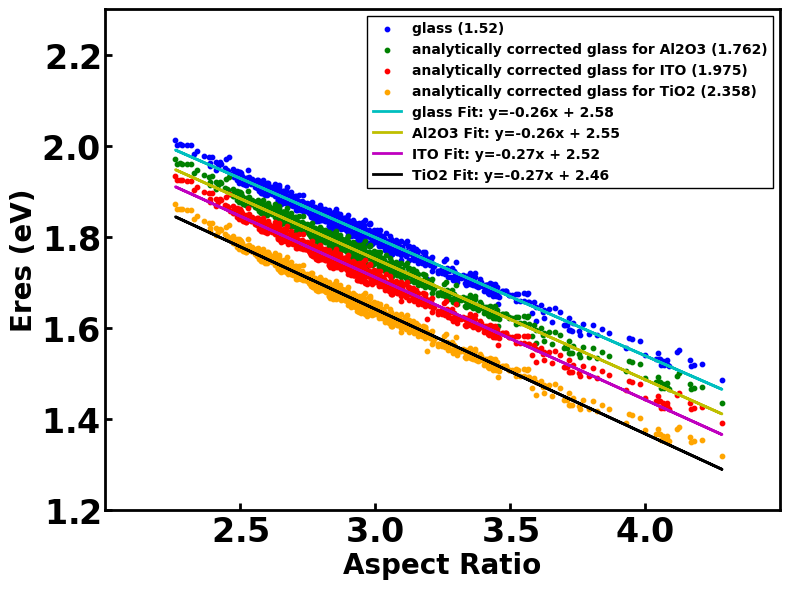

In [5]:
# Eres vs AR ITO and glass
plt.scatter(glass_data['ratio'], glass_data['eres'], s=10, c='b', label='glass (1.52)')
plt.scatter(glass_data['ratio'], glass_data['eres']*F_Al2O3, c='g', s=10, label='analytically corrected glass for Al2O3 (1.762)')
plt.scatter(glass_data['ratio'], glass_data['eres']*F_ITO, s=10, c='r', label='analytically corrected glass for ITO (1.975)')
plt.scatter(glass_data['ratio'], glass_data['eres']*F_TiO2, s=10, c='orange', label='analytically corrected glass for TiO2 (2.358)')

# Perform linear regression
model_glass = LinearRegression()
model_glass.fit(glass_data['ratio'].values.reshape(-1, 1), glass_data['eres'])
slope_glass, intercept_glass = model_glass.coef_[0], model_glass.intercept_
plt.plot(glass_data['ratio'], slope_glass * glass_data['ratio'] + intercept_glass, c='c', lw=2, label=f'glass Fit: y={slope_glass:.2f}x + {intercept_glass:.2f}')

model_Al2O3 = LinearRegression()
model_Al2O3.fit(glass_data['ratio'].values.reshape(-1, 1), glass_data['eres']*F_Al2O3)
slope_Al2O3, intercept_Al2O3 = model_Al2O3.coef_[0], model_Al2O3.intercept_
plt.plot(glass_data['ratio'], slope_Al2O3 * glass_data['ratio'] + intercept_Al2O3, c='y', lw=2, label=f'Al2O3 Fit: y={slope_Al2O3:.2f}x + {intercept_Al2O3:.2f}')

model_ITO = LinearRegression()
model_ITO.fit(glass_data['ratio'].values.reshape(-1, 1), glass_data['eres']*F_ITO)
slope_ITO, intercept_ITO = model_ITO.coef_[0], model_ITO.intercept_
plt.plot(glass_data['ratio'], slope_ITO * glass_data['ratio'] + intercept_ITO, c='m', lw=2, label=f'ITO Fit: y={slope_ITO:.2f}x + {intercept_ITO:.2f}')

model_TiO2 = LinearRegression()
model_TiO2.fit(glass_data['ratio'].values.reshape(-1, 1), glass_data['eres']*F_TiO2)
slope_TiO2, intercept_TiO2 = model_TiO2.coef_[0], model_TiO2.intercept_
plt.plot(glass_data['ratio'], slope_TiO2 * glass_data['ratio'] + intercept_TiO2, c='k', lw=2, label=f'TiO2 Fit: y={slope_TiO2:.2f}x + {intercept_TiO2:.2f}')

plt.xlabel('Aspect Ratio')
plt.ylabel('Eres (eV)')
plt.xticks([2.5, 3.0, 3.5, 4.0])
plt.xlim(2, 4.5)
plt.ylim(1.2, 2.3)
plt.legend()

# numerical method for correction of AuNRs 

In [3]:
def calc_dif(idx, ito_data, glass_data):
    Eres_glass = glass_data['eres'][idx]
    Linewidth_glass = glass_data['linewidth'][idx]
    AR_glass = glass_data['ratio'][idx]

    upper_min = ito_data[ito_data['ratio'] > AR_glass]['ratio'].min()
    lower_max = ito_data[ito_data['ratio'] < AR_glass]['ratio'].max()

    if abs(upper_min - AR_glass) > abs(lower_max - AR_glass):
        AR_ito_closest = lower_max
    else:
        AR_ito_closest = upper_min

    Eres_ito = ito_data[ito_data['ratio'] == AR_ito_closest]['eres']
    Linewidth_ito = ito_data[ito_data['ratio'] == AR_ito_closest]['linewidth']
    dEres_IG = Eres_ito - Eres_glass
    dLinewidth_IG = Linewidth_ito - Linewidth_glass
    return dEres_IG, dLinewidth_IG


def calculate_mean(lst):
    return sum(lst) / len(lst)


def numerical_method(ito_data, glass_data, target_nsub):
    ito_nsub = 1.975
    glass_nsub = 1.52
    dnsub_IG = ito_nsub - glass_nsub
    dEres_IG_list = []
    dLinewidth_IG_list = []
    for idx in range(glass_data.shape[0]):
        dEres_IG, dLinewidth_IG = calc_dif(idx, ito_data, glass_data)
        if (dEres_IG.shape == (1,)) and (dLinewidth_IG.shape == (1,)): 
            dEres_IG_list.append(dEres_IG.values)
            dLinewidth_IG_list.append(dLinewidth_IG.values)

    dEres_IG_mean = calculate_mean(dEres_IG_list)
    dLinewidth_IG_mean = calculate_mean(dLinewidth_IG_list)
    C = dEres_IG_mean / dnsub_IG
    D = dLinewidth_IG_mean / dnsub_IG
    target_Eres = C*(target_nsub - glass_nsub) + glass_data['eres']
    target_Linewidth = D*(target_nsub - glass_nsub) + glass_data['linewidth']
    return target_Eres, target_Linewidth

In [4]:
Al2O3_nsub = 1.762
ITO_nsub = 1.975
TiO2_nsub = 2.358
Al2O3_Eres, Al2O3_Linewidth = numerical_method(ito_data, glass_data, target_nsub=Al2O3_nsub)
ITO_Eres, ITO_Linewidth = numerical_method(ito_data, glass_data, target_nsub=ITO_nsub)
TiO2_Eres, TiO2_Linewidth = numerical_method(ito_data, glass_data, target_nsub=TiO2_nsub)

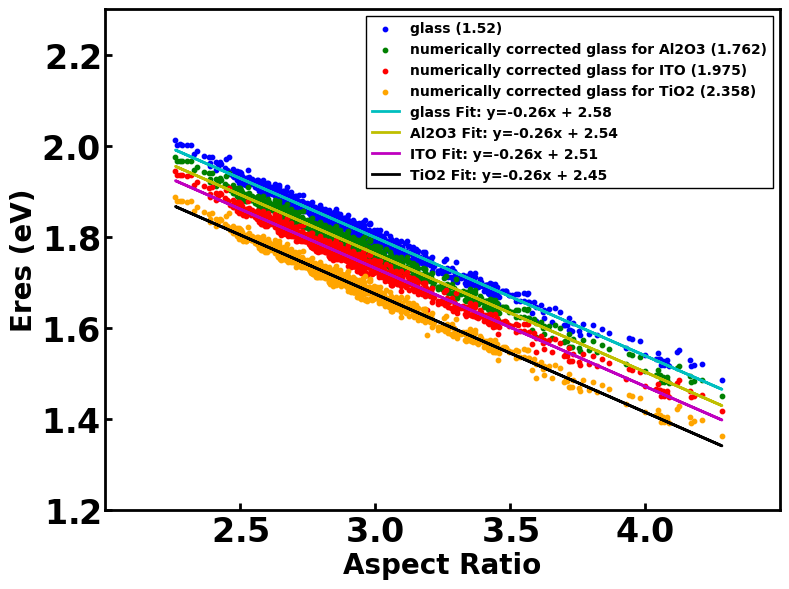

In [5]:
plt.scatter(glass_data['ratio'], glass_data['eres'], s=10, c='b', label='glass (1.52)')
plt.scatter(glass_data['ratio'], Al2O3_Eres, s=10, c='g', label='numerically corrected glass for Al2O3 (1.762)')
plt.scatter(glass_data['ratio'], ITO_Eres, s=10, c='r', label='numerically corrected glass for ITO (1.975)')
plt.scatter(glass_data['ratio'], TiO2_Eres, s=10, c='orange', label='numerically corrected glass for TiO2 (2.358)')

# Perform linear regression
model_glass = LinearRegression()
model_glass.fit(glass_data['ratio'].values.reshape(-1, 1), glass_data['eres'])
slope_glass, intercept_glass = model_glass.coef_[0], model_glass.intercept_
plt.plot(glass_data['ratio'], slope_glass * glass_data['ratio'] + intercept_glass, c='c', lw=2, label=f'glass Fit: y={slope_glass:.2f}x + {intercept_glass:.2f}')

model_Al2O3 = LinearRegression()
model_Al2O3.fit(glass_data['ratio'].values.reshape(-1, 1), Al2O3_Eres)
slope_Al2O3, intercept_Al2O3 = model_Al2O3.coef_[0], model_Al2O3.intercept_
plt.plot(glass_data['ratio'], slope_Al2O3 * glass_data['ratio'] + intercept_Al2O3, c='y', lw=2, label=f'Al2O3 Fit: y={slope_Al2O3:.2f}x + {intercept_Al2O3:.2f}')

model_ITO = LinearRegression()
model_ITO.fit(glass_data['ratio'].values.reshape(-1, 1), ITO_Eres)
slope_ITO, intercept_ITO = model_ITO.coef_[0], model_ITO.intercept_
plt.plot(glass_data['ratio'], slope_ITO * glass_data['ratio'] + intercept_ITO, c='m', lw=2, label=f'ITO Fit: y={slope_ITO:.2f}x + {intercept_ITO:.2f}')

model_TiO2 = LinearRegression()
model_TiO2.fit(glass_data['ratio'].values.reshape(-1, 1), TiO2_Eres)
slope_TiO2, intercept_TiO2 = model_TiO2.coef_[0], model_TiO2.intercept_
plt.plot(glass_data['ratio'], slope_TiO2 * glass_data['ratio'] + intercept_TiO2, c='k', lw=2, label=f'TiO2 Fit: y={slope_TiO2:.2f}x + {intercept_TiO2:.2f}')

plt.xlabel('Aspect Ratio')
plt.ylabel('Eres (eV)')
plt.xticks([2.5, 3.0, 3.5, 4.0])
plt.xlim(2, 4.5)
plt.ylim(1.2, 2.3)
plt.legend()

# Linewidth

# Comparisons